In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import ast
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans , DBSCAN , MeanShift
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df = pd.read_csv('/content/drive/MyDrive/final_features.csv')

# correlation

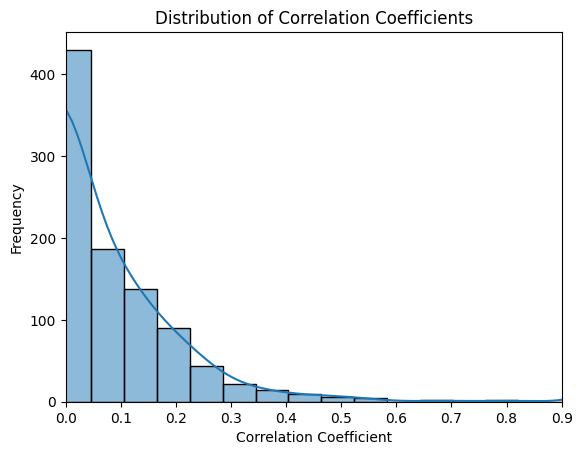

In [4]:
def clean_data(value):
    if isinstance(value, str) and value.startswith('[') and value.endswith(']'):
        try:
            value_list = ast.literal_eval(value)
            return np.mean(value_list)
        except:
            return np.nan
    else:
        return value


# df = df.drop(columns=["eye_color", "skin_color"])

df = df.drop(columns=['image_id'])
df_cleaned = df.iloc[:, 1:].apply(clean_data)

data = df_cleaned.astype(float).values

# Calculation of Pearson correlation matrix
def pearson_correlation(x, y):
    mean_x, mean_y = np.mean(x), np.mean(y)
    numerator = np.sum((x - mean_x) * (y - mean_y))
    denominator = np.sqrt(np.sum((x - mean_x)**2) * np.sum((y - mean_y)**2))
    return numerator / denominator

def compute_correlation_matrix(data):
    num_features = data.shape[1]
    correlation_matrix = np.zeros((num_features, num_features))
    for i in range(num_features):
        for j in range(num_features):
            if i == j:
                correlation_matrix[i][j] = 1
            else:
                correlation_matrix[i][j] = pearson_correlation(data[:, i], data[:, j])
    return correlation_matrix

correlation_matrix = compute_correlation_matrix(data)

plt.figure(figsize=(6.4, 4.8))
sns.histplot(correlation_matrix.flatten(), bins=30, kde=True)
plt.xlim(0, 0.9)
plt.title('Distribution of Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()


# plt.figure(figsize=(20,20))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Pearson Correlation Matrix')
# plt.show()


# featuer selection

In [5]:
threshold = 0.17

columns_to_drop = set()
num_features = correlation_matrix.shape[0]
for i in range(num_features):
    for j in range(i):
        if abs(correlation_matrix[i, j]) > threshold:
            columns_to_drop.add(i)

data_reduced = np.delete(data, list(columns_to_drop), axis=1)
feature_names = df.columns
kept_features = np.delete(feature_names, list(columns_to_drop))
features_array = kept_features.to_numpy()
print(features_array)

print(f"Number of features kept: {data_reduced.shape[1]}")

['5_o_Clock_Shadow' 'Bags_Under_Eyes' 'Bald' 'Big_Nose' 'Mustache'
 'Oval_Face' 'Smiling' 'Wearing_Earrings' 'Young' 'skin_color' 'eye_color']
Number of features kept: 10


# elbow method

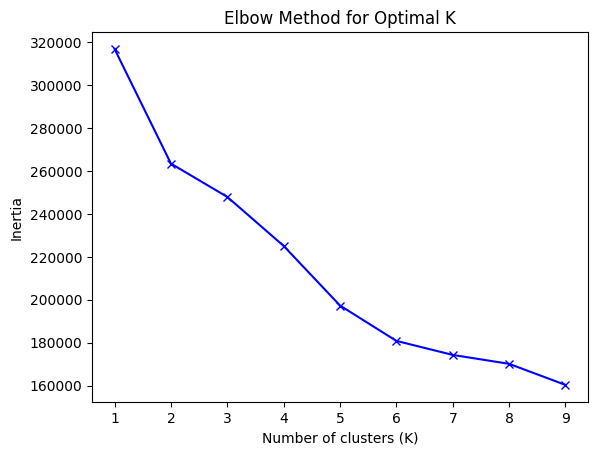

In [ ]:
selected_Kmeans_1 = df[features_array].select_dtypes(include=[int, float])

inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(selected_Kmeans_1)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


# kmeans without skin and eyes

Silhouette Score: 0.22621722301176186


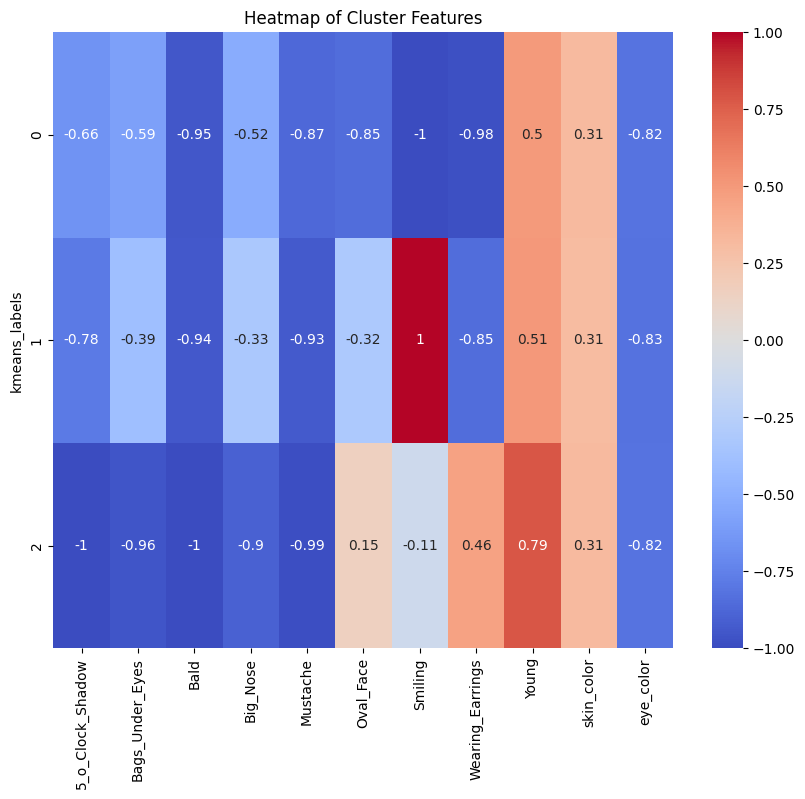

In [ ]:
# X = df.drop(columns=['skin_color', 'eye_color'])
# print(X.columns)
# filtered_features_array = [col for col in features_array if col in X.columns]
# selected_Kmeans_1 = X[filtered_features_array].select_dtypes(include=[int, float])

X = df
selected_Kmeans_1 = X[features_array].select_dtypes(include=[int, float])
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(selected_Kmeans_1)
selected_Kmeans_1['kmeans_labels'] = kmeans.labels_
df['kmeans_labels'] = kmeans.labels_

silhouette_avg = silhouette_score(selected_Kmeans_1, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

# df.drop(columns=['image_id'])
heatmap_data = selected_Kmeans_1.groupby('kmeans_labels').mean()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Heatmap of Cluster Features')
plt.show()

# kmeans with skin and eyes

Silhouette Score: 0.37521022027267165


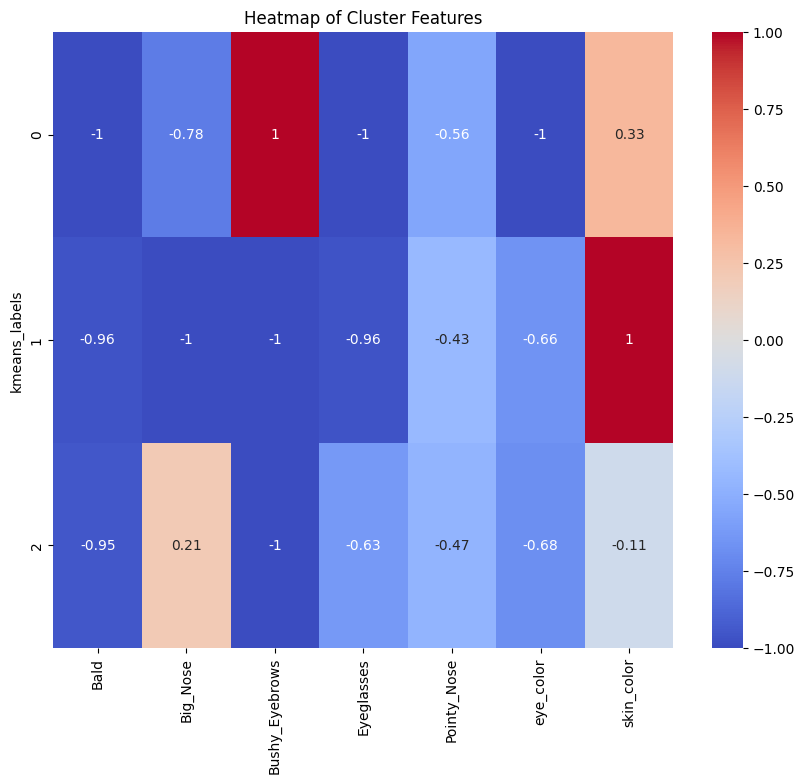

In [ ]:
selected_features_8 = list(features_array)
# selected_features_8.append('skin_color')
# selected_features_8.append('eye_color')

selected_Kmeans_2 = df[selected_features_8].select_dtypes(include=[int, float])
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(selected_Kmeans_2)
selected_Kmeans_2['kmeans_labels'] = kmeans.labels_
df['kmeans_labels'] =  kmeans.labels_

silhouette_avg = silhouette_score(selected_Kmeans_2, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')
df.drop(columns=['image_id'])
heatmap_data = selected_Kmeans_2.groupby('kmeans_labels').mean()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Heatmap of Cluster Features')
plt.show()



# knn

In [ ]:
selected_knn = df[features_array].select_dtypes(include=[int, float])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(selected_knn)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(selected_knn)

centers = kmeans.cluster_centers_

selected_knn['kmeans_labels'] = kmeans.labels_
df['kmeans_labels'] = kmeans.labels_

def find_nearest_points(knn_model, centers, original_data):
    results = {}
    for idx, center in enumerate(centers):
        distances, indices = knn_model.kneighbors([center])
        results[idx] = indices[0]
    return results

n_samples = X_scaled.shape[0]

n_neighbors_50 = min(50, n_samples)
knn_50 = NearestNeighbors(n_neighbors=n_neighbors_50)
knn_50.fit(X_scaled)

n_neighbors_3000 = min(3000, n_samples)
knn_3000 = NearestNeighbors(n_neighbors=n_neighbors_3000)
knn_3000.fit(X_scaled)

nearest_50 = find_nearest_points(knn_50, centers, X_scaled)
nearest_3000 = find_nearest_points(knn_3000, centers, X_scaled)

for cluster_id, indices in nearest_50.items():
    cluster_labels = selected_knn.iloc[indices]['kmeans_labels']
    print(f'Cluster {cluster_id} - Closest 50 points labels: {cluster_labels.value_counts()}')

for cluster_id, indices in nearest_3000.items():
    cluster_labels = selected_knn.iloc[indices]['kmeans_labels']
    print(f'Cluster {cluster_id} - Closest 3000 points labels: {cluster_labels.value_counts()}')

for cluster_id, indices in nearest_3000.items():
    cluster_labels = selected_knn.iloc[indices]['kmeans_labels']
    print(f"Cluster {cluster_id}: Non-matching cluster data:\n", cluster_labels[cluster_labels != cluster_id].value_counts())


Cluster 0 - Closest 50 points labels: kmeans_labels
0    50
Name: count, dtype: int64
Cluster 1 - Closest 50 points labels: kmeans_labels
1    50
Name: count, dtype: int64
Cluster 2 - Closest 50 points labels: kmeans_labels
0    50
Name: count, dtype: int64
Cluster 0 - Closest 3000 points labels: kmeans_labels
0    3000
Name: count, dtype: int64
Cluster 1 - Closest 3000 points labels: kmeans_labels
1    3000
Name: count, dtype: int64
Cluster 2 - Closest 3000 points labels: kmeans_labels
0    3000
Name: count, dtype: int64
Cluster 0: Non-matching cluster data:
 Series([], Name: count, dtype: int64)
Cluster 1: Non-matching cluster data:
 Series([], Name: count, dtype: int64)
Cluster 2: Non-matching cluster data:
 kmeans_labels
0    3000
Name: count, dtype: int64


# k-distance

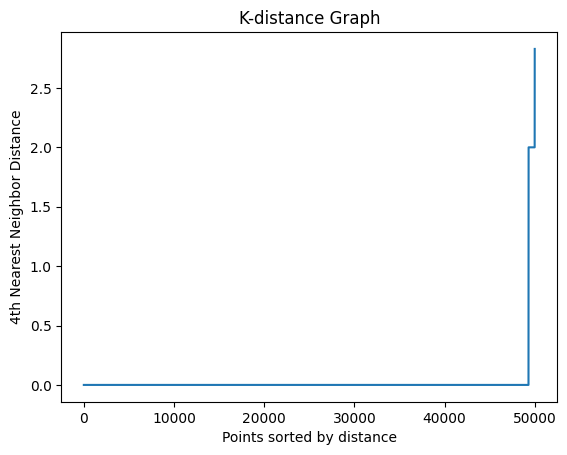

In [ ]:
selected = df[features_array].select_dtypes(include=[int, float])
nearest_neighbors = NearestNeighbors(n_neighbors=800)
neighbors = nearest_neighbors.fit(selected)
distances, indices = neighbors.kneighbors(selected)

distances = np.sort(distances[:, 4], axis=0)
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.title("K-distance Graph")
plt.show()


# **dbscan**

Estimated number of clusters: 25
Estimated number of noise points: 20630
Silhouette Score: 0.5595089399998469


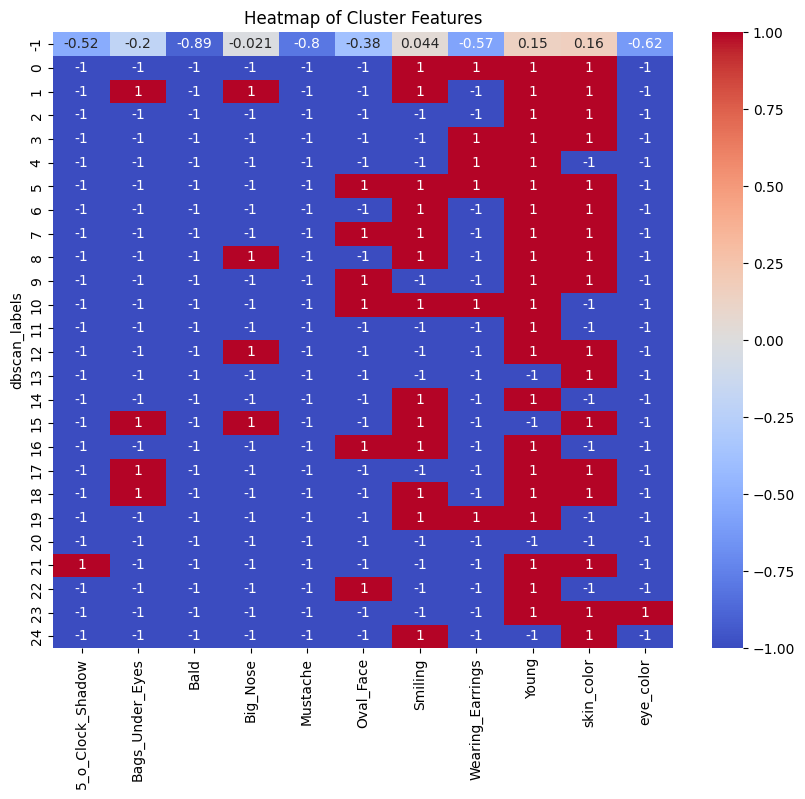

In [6]:
# X = df.drop(columns=['skin_color'])
selected_DBscan = df[features_array].select_dtypes(include=[int, float])

eps = 1.9
min_samples = 400
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(selected_DBscan)
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

selected_DBscan['dbscan_labels'] = labels

silhouette_avg = silhouette_score(selected_DBscan, dbscan.labels_)
print(f'Silhouette Score: {silhouette_avg}')
heatmap_data = selected_DBscan.groupby('dbscan_labels').mean()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Heatmap of Cluster Features')
plt.show()

# **meanshift**

Silhouette Score: 0.24461087028164824


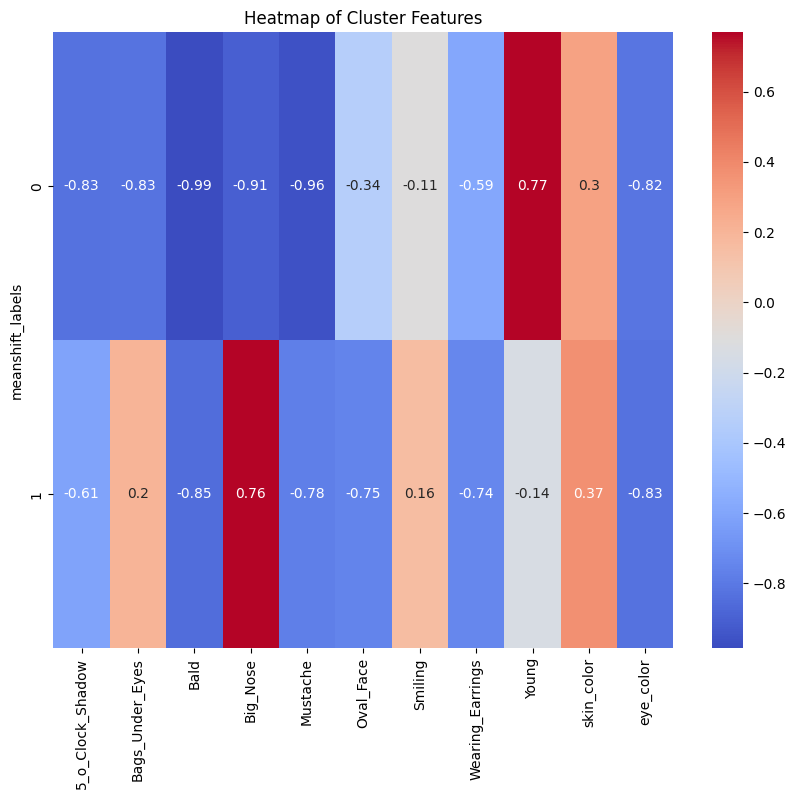

In [8]:
selected_meanshift = df[features_array].select_dtypes(include=[int, float])

meanshift = MeanShift(bandwidth=2.5)
meanshift.fit(selected_meanshift)
labels = meanshift.labels_
centroids = meanshift.cluster_centers_

selected_meanshift['meanshift_labels'] = labels

silhouette_avg = silhouette_score(selected_meanshift, meanshift.labels_)
print(f'Silhouette Score: {silhouette_avg}')
heatmap_data = selected_meanshift.groupby('meanshift_labels').mean()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Heatmap of Cluster Features')
plt.show()

# save 10 pic

In [ ]:
image_folder = '/content/drive/MyDrive/dataset'
output_folder = '/content/drive/MyDrive/clustered_images_kmeans'

for cluster_label in set(df['kmeans_labels']):
    cluster_folder = os.path.join(output_folder, f'cluster_{cluster_label}')
    os.makedirs(cluster_folder, exist_ok=True)

for cluster_label in set(df['kmeans_labels']):
    cluster_indices = df[df['kmeans_labels'] == cluster_label].index[:10]

    cluster_folder = os.path.join(output_folder, f'cluster_{cluster_label}')

    for idx in cluster_indices:
        image_name = f'{idx + 1:06d}.jpg'
        image_path = os.path.join(image_folder, image_name)

        if os.path.exists(image_path):
            shutil.copy(image_path, cluster_folder)
        else:
            print(f"Image not found: {image_path}")

print('Images have been saved in respective cluster folders.')


Images have been saved in respective cluster folders.


In [ ]:
image_folder = '/content/drive/MyDrive/dataset'
output_folder = '/content/drive/MyDrive/clustered_images_dbscan'

for cluster_label in set(selected_DBscan['dbscan_labels']):
    if cluster_label != -1:
        cluster_folder = os.path.join(output_folder, f'cluster_{cluster_label}')
        os.makedirs(cluster_folder, exist_ok=True)

for cluster_label in set(selected_DBscan['dbscan_labels']):
    if cluster_label != -1:
        cluster_indices = selected_DBscan[selected_DBscan['dbscan_labels'] == cluster_label].index[:10]

        cluster_folder = os.path.join(output_folder, f'cluster_{cluster_label}')

        for idx in cluster_indices:
            image_name = f'{idx + 1:06d}.jpg'
            image_path = os.path.join(image_folder, image_name)

            if os.path.exists(image_path):
                shutil.copy(image_path, cluster_folder)
            else:
                print(f"Image not found: {image_path}")

print('Images have been saved in respective cluster folders for DBSCAN.')


Images have been saved in respective cluster folders for DBSCAN.


In [9]:
image_folder = '/content/drive/MyDrive/dataset'
output_folder = '/content/drive/MyDrive/clustered_images_meanshift'

for cluster_label in set(selected_meanshift['meanshift_labels']):
    cluster_folder = os.path.join(output_folder, f'cluster_{cluster_label}')
    os.makedirs(cluster_folder, exist_ok=True)

for cluster_label in set(selected_meanshift['meanshift_labels']):
    cluster_indices = selected_meanshift[selected_meanshift['meanshift_labels'] == cluster_label].index[:10]

    cluster_folder = os.path.join(output_folder, f'cluster_{cluster_label}')

    for idx in cluster_indices:
        image_name = f'{idx + 1:06d}.jpg'
        image_path = os.path.join(image_folder, image_name)

        if os.path.exists(image_path):
            shutil.copy(image_path, cluster_folder)
        else:
            print(f"Image not found: {image_path}")

print('Images have been saved in respective cluster folders for Mean Shift.')


Image not found: /content/drive/MyDrive/dataset/000001.jpg
Images have been saved in respective cluster folders for Mean Shift.


# kmeans visualisation

Explained variance by 2 PCA components: [0.18977945 0.18276235]


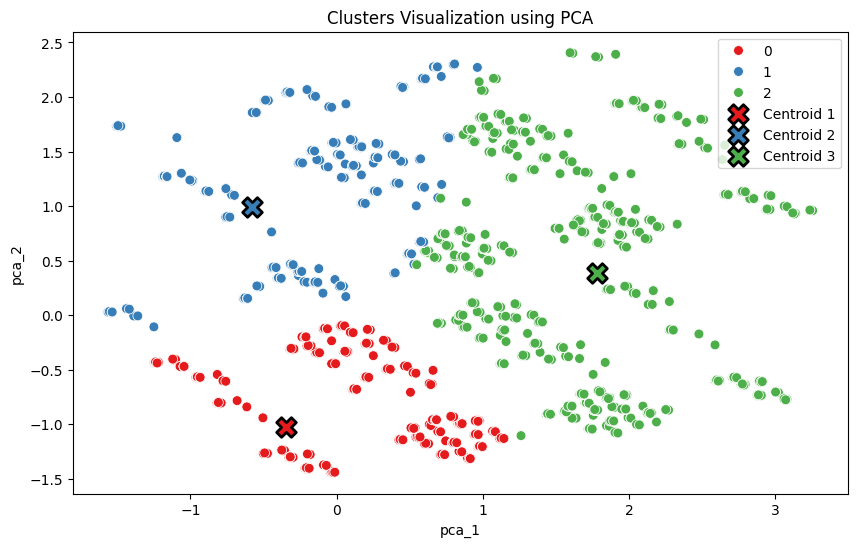

In [ ]:
# px = df.drop(columns=['skin_color'])
px = df[features_array].select_dtypes(include=[int, float])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(px)


print(f"Explained variance by 2 PCA components: {pca.explained_variance_ratio_}")

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_result)
centroids_pca = kmeans.cluster_centers_

px['pca_1'] = pca_result[:, 0]
px['pca_2'] = pca_result[:, 1]
px['cluster'] = clusters

plt.figure(figsize=(10, 6))
palette = sns.color_palette('Set1', n_colors=len(np.unique(clusters)))
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', palette=palette, data=px, s=50)

for i, centroid in enumerate(centroids_pca):
    plt.scatter(centroid[0], centroid[1], s=200, color=palette[i], marker='X', edgecolor='black', linewidth=2, label=f'Centroid {i+1}')

plt.title('Clusters Visualization using PCA')
plt.legend()
plt.show()


# dbscan visualisation

Explained variance by 2 PCA components: [0.18977945 0.18276235]


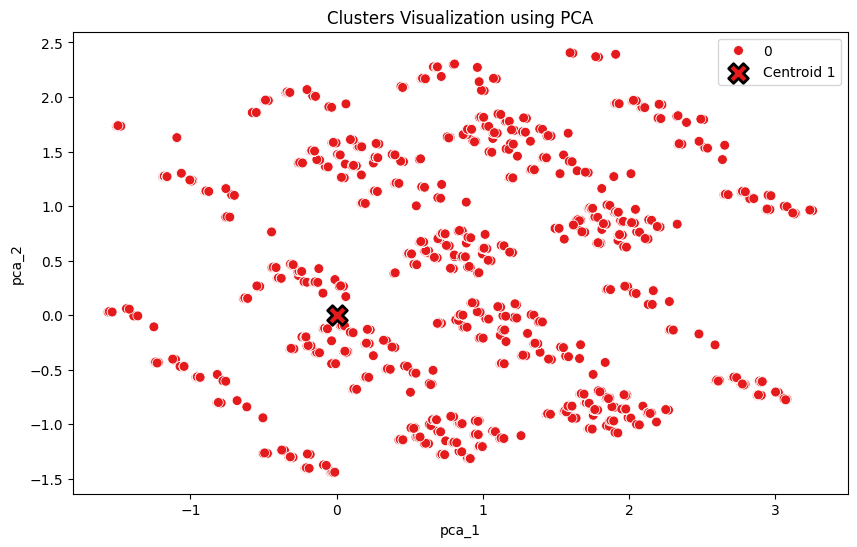

In [7]:
# px = df.drop(columns=['skin_color'])
px = df[features_array].select_dtypes(include=[int, float])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(px)

print(f"Explained variance by 2 PCA components: {pca.explained_variance_ratio_}")

clusters = dbscan.fit_predict(pca_result)

unique_clusters = np.unique(clusters)
unique_clusters = unique_clusters[unique_clusters != -1]

centroids_pca = []
for cluster in unique_clusters:
    cluster_points = pca_result[clusters == cluster]
    centroid = np.mean(cluster_points, axis=0)
    centroids_pca.append(centroid)

centroids_pca = np.array(centroids_pca)

px['pca_1'] = pca_result[:, 0]
px['pca_2'] = pca_result[:, 1]
px['cluster'] = clusters

plt.figure(figsize=(10, 6))
palette = sns.color_palette('Set1', n_colors=len(np.unique(clusters)))
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', palette=palette, data=px, s=50)

for i, centroid in enumerate(centroids_pca):
    plt.scatter(centroid[0], centroid[1], s=200, color=palette[i], marker='X', edgecolor='black', linewidth=2, label=f'Centroid {i+1}')

plt.title('Clusters Visualization using PCA')
plt.legend()
plt.show()

# meanshift visualisation

Explained variance by 2 PCA components: [0.18977945 0.18276235]


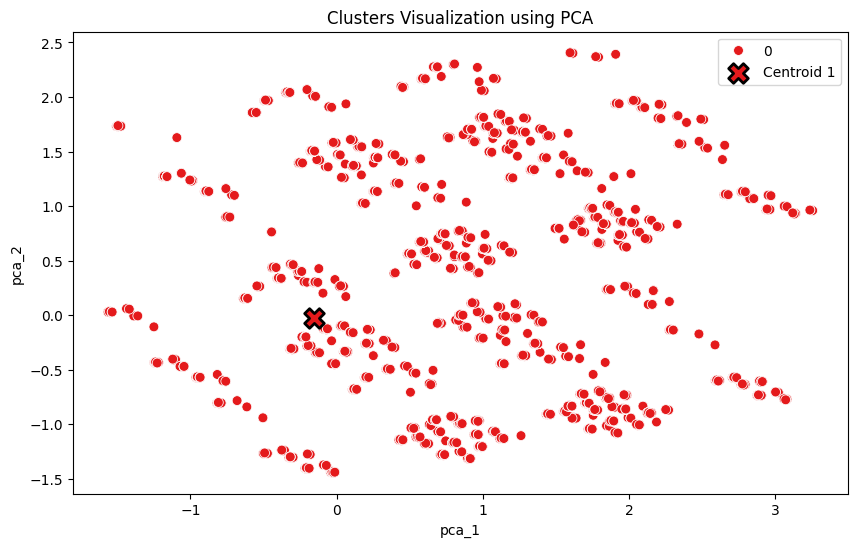

In [10]:
# px = df.drop(columns=['skin_color'])
px = df[features_array].select_dtypes(include=[int, float])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(px)

print(f"Explained variance by 2 PCA components: {pca.explained_variance_ratio_}")

clusters = meanshift.fit_predict(pca_result)
centroids_pca = meanshift.cluster_centers_

px['pca_1'] = pca_result[:, 0]
px['pca_2'] = pca_result[:, 1]
px['cluster'] = clusters

plt.figure(figsize=(10, 6))
palette = sns.color_palette('Set1', n_colors=len(np.unique(clusters)))
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', palette=palette, data=px, s=50)

for i, centroid in enumerate(centroids_pca):
    plt.scatter(centroid[0], centroid[1], s=200, color=palette[i], marker='X', edgecolor='black', linewidth=2, label=f'Centroid {i+1}')

plt.title('Clusters Visualization using PCA')
plt.legend()
plt.show()


# Prediction

<ipython-input-9-07c643668655>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = test_data.groupby('predicted_cluster').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)


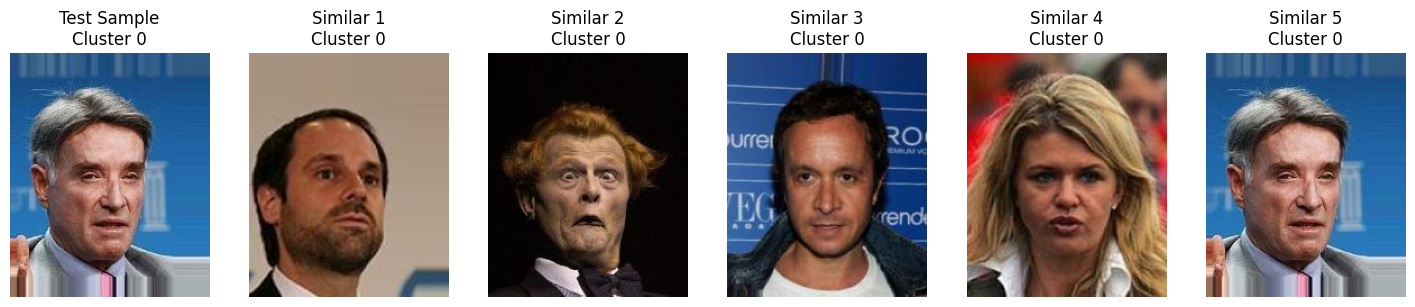

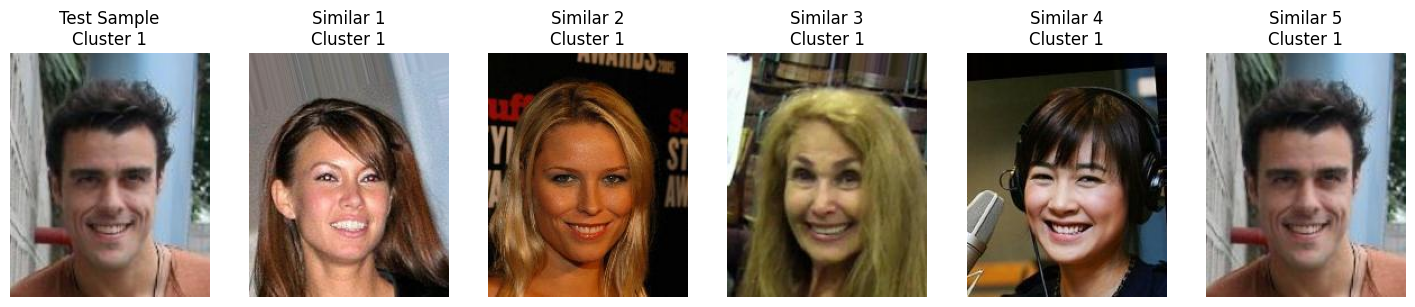

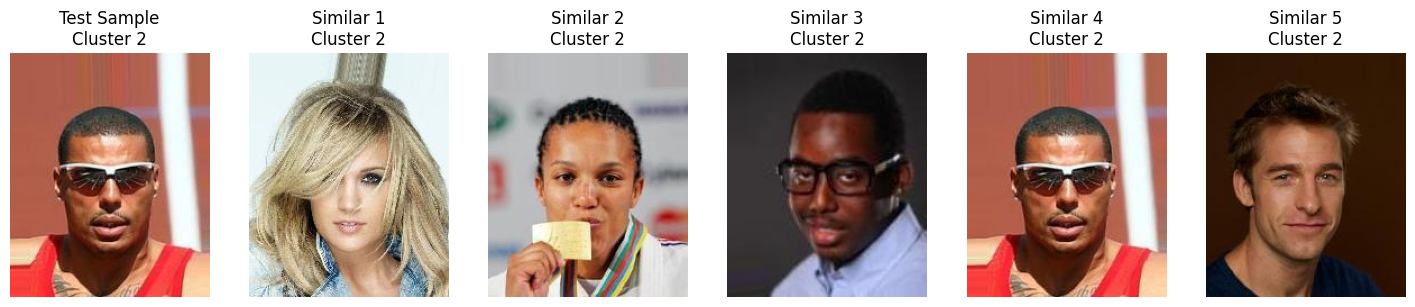

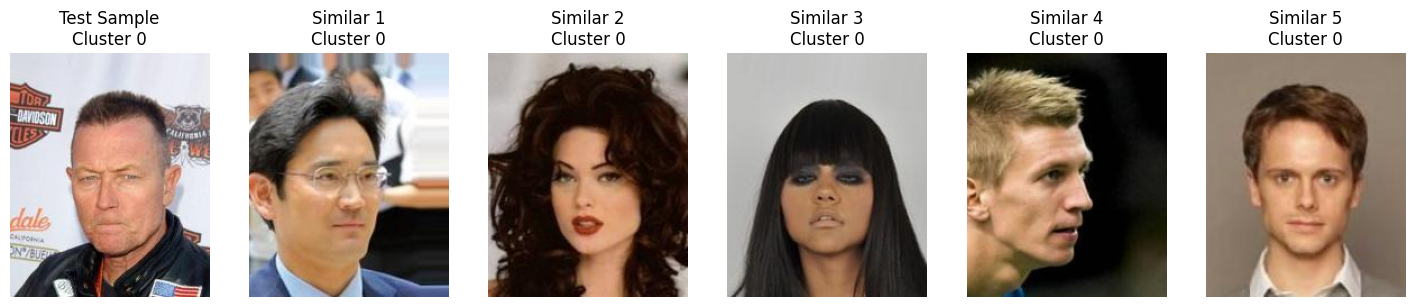

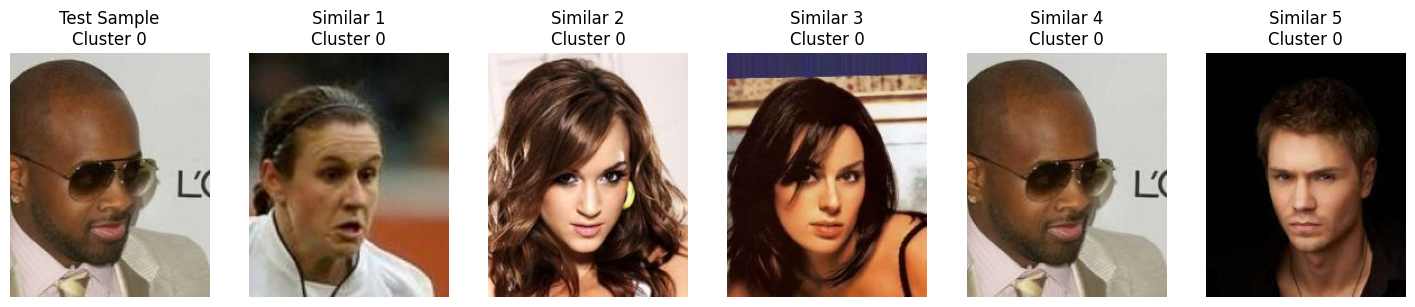

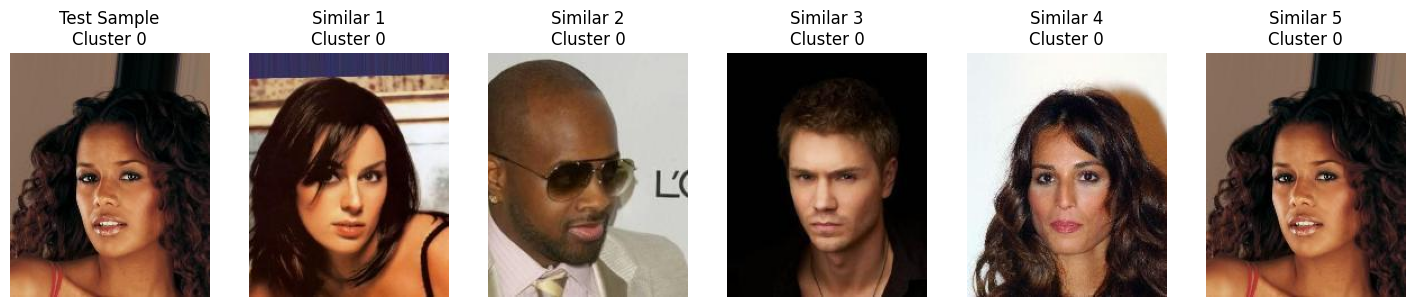

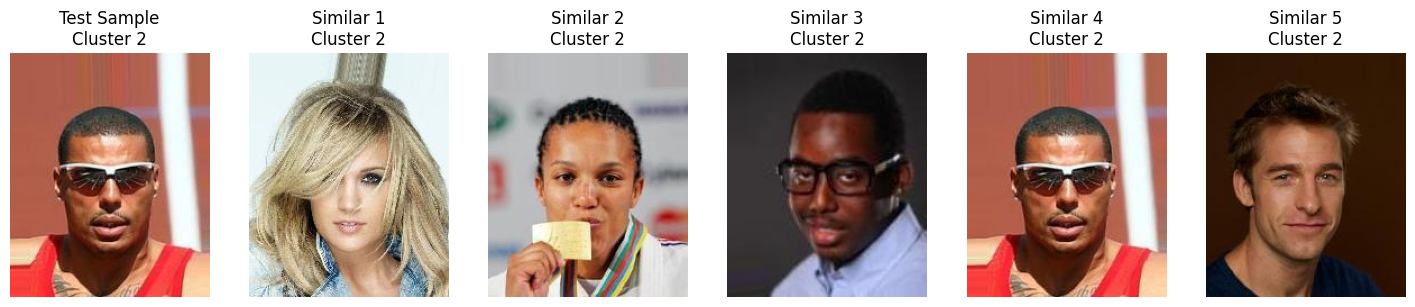

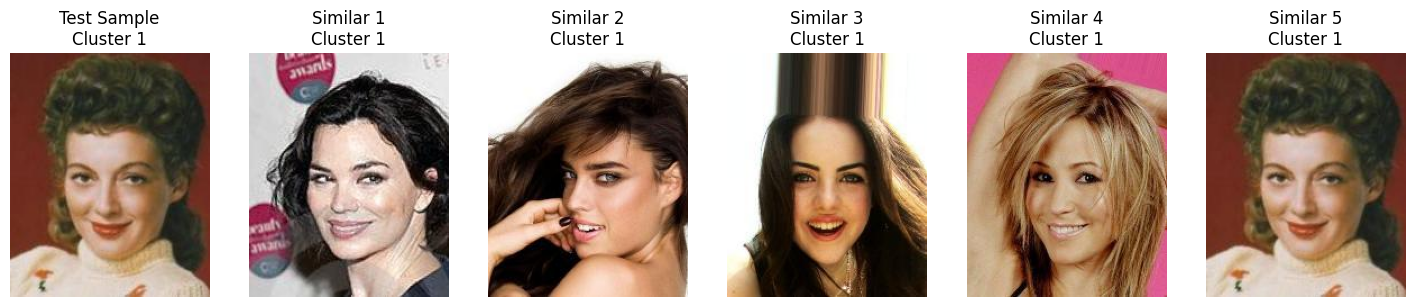

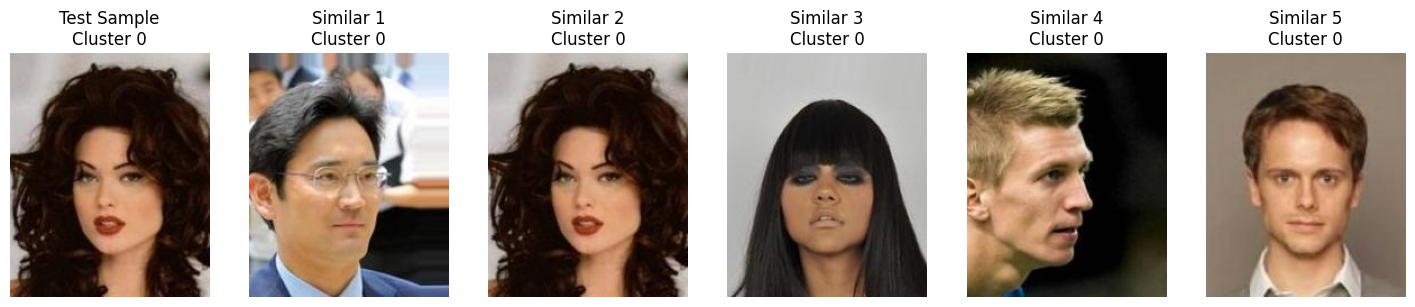

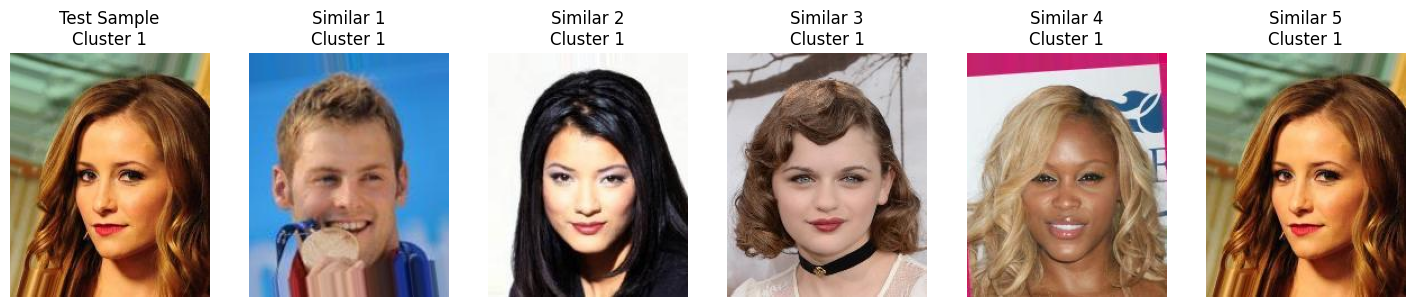

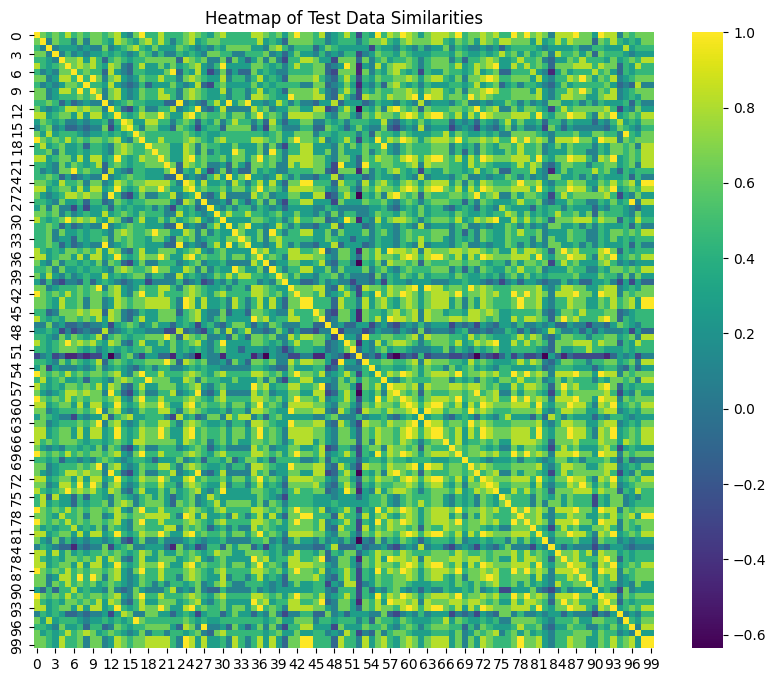

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/final_test_features.csv')
test_features = test_data[features_array].select_dtypes(include=[int, float])

try:
    test_data['predicted_cluster'] = kmeans.predict(test_features)
except NameError:
    print("Error: KMeans model 'kmeans' is not defined. Please ensure it is trained.")

sampled_data = test_data.groupby('predicted_cluster').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

if len(sampled_data) < 10:
    additional_samples = test_data[~test_data.index.isin(sampled_data.index)].sample(n=10 - len(sampled_data), random_state=42)
    selected_test_samples = pd.concat([sampled_data, additional_samples]).reset_index(drop=True)
else:
    selected_test_samples = sampled_data

image_directory = '/content/drive/MyDrive/test/'

for _, test_sample in selected_test_samples.iterrows():
    cluster = test_sample['predicted_cluster']

    cluster_data = test_data[test_data['predicted_cluster'] == cluster]

    test_sample_features = test_sample[features_array].values.reshape(1, -1)
    cluster_features = cluster_data[features_array].values

    similarities = cosine_similarity(test_sample_features, cluster_features)

    closest_indices = np.argsort(similarities[0])[-5:]
    closest_samples = cluster_data.iloc[closest_indices]

    fig, axes = plt.subplots(1, 6, figsize=(18, 4))

    test_image_path = f"{image_directory}{test_sample['image_id']}"
    test_image = Image.open(test_image_path)
    axes[0].imshow(test_image, cmap='gray')
    axes[0].set_title(f"Test Sample\nCluster {cluster}")
    axes[0].axis('off')

    for i, (_, similar_sample) in enumerate(closest_samples.iterrows()):
        similar_image_path = f"{image_directory}{similar_sample['image_id']}"
        similar_image = Image.open(similar_image_path)
        similar_cluster = similar_sample['predicted_cluster']
        axes[i + 1].imshow(similar_image, cmap='gray')
        axes[i + 1].set_title(f"Similar {i + 1}\nCluster {similar_cluster}")
        axes[i + 1].axis('off')

    plt.show()

test_data.to_csv('test_data_with_clusters.csv', index=False)

similarity_matrix = cosine_similarity(test_features)
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title("Heatmap of Test Data Similarities")
plt.show()
